# Reinforcement Learning

### Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from os import path, walk
import torch.nn as nn
from IPython.display import Audio, display
from tqdm import tqdm

### Hyperparameters

In [ ]:
fs = 8000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Data collecting function

In [ ]:
def initial_states_to_list(random_sampling_file):
    initial_states = list()
    f = open(random_sampling_file, "r")
    for line in f:
        brir, file = line.split(" ")
        initial_states.append((brir, file.removesuffix("\n")))
    f.close()
    return initial_states

## Deep Q-network

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_angles):
        super(DQN, self).__init__()
        self.n_hidden = 1000
        self.gru1 = nn.GRU(n_observations, 256, 1, batch_first=True, bidirectional=False)
        self.gru2 = nn.GRU(256, 128, 1, batch_first=True, bidirectional=False)
        self.gru3 = nn.GRU(128, 64, 1, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(64*2, n_angles)
        self.dropout20 = nn.Dropout(p=0.2)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.dropout20(x)
        x, _ = self.gru2(x)
        x = self.dropout20(x)
        x, _ = self.gru3(x)
        x = self.dropout50(x)
        x = torch.cat((x[:,0,:],x[:,1,:]), dim=1)
        x = self.fc(x)
        return x

## Memory buffer

In [ ]:
class MemoryBuffer():
    def __init__(self, buffer_length, batch_size):
        self.buffer_length = buffer_length
        self.idx = 0
        self.s_buffer = torch.zeros((self.buffer_length, 2, 4000))
        self.a_buffer = torch.zeros((self.buffer_length, 1), dtype=torch.int)
        self.s1_buffer = torch.zeros((self.buffer_length, 2, 4000))
        self.r_buffer = torch.zeros((self.buffer_length, 1))
        self.t_buffer = torch.zeros((self.buffer_length, 1), dtype=torch.bool)
        self.batch_size = batch_size

    def add_into_buffer(self, s, a, s_prime, r, t):
        """
        Function that adds a <s,a,s',r> tuple into the buffer.
        s: state
        a: action
        s_prime: new state
        r: reward
        """
        self.s_buffer[self.idx % self.buffer_length] = s
        self.a_buffer[self.idx % self.buffer_length] = torch.tensor([a], dtype=torch.int)
        self.s1_buffer[self.idx % self.buffer_length] = s_prime
        self.r_buffer[self.idx % self.buffer_length] = torch.tensor([r])
        self.t_buffer[self.idx % self.buffer_length] = torch.tensor([t], dtype=torch.bool)
        if self.idx < self.buffer_length:
            self.idx += 1
        else:
            self.idx += 2


    def sample_from_buffer(self):
        """
        Function that returns random samples from the buffer.
        """
        indices = torch.randperm(min(self.idx, self.batch_size))[:self.batch_size]
        return self.s_buffer[indices], self.a_buffer[indices], \
        self.s1_buffer[indices], self.r_buffer[indices], self.t_buffer[indices]


class BalancedMemoryBuffer():
    def __init__(self, batch_size, num_classes, az_angles, el_angles):
        self.device = torch.device("cuda")

        self.az_angles = az_angles
        self.el_angles = el_angles

        self.buffer_length = 100000
        self.start_buffer_length = 5000
        self.class_buffer_length = 1000
        self.num_classes = 65
        self.batch_size = batch_size

        self.start_s = torch.empty((self.start_buffer_length, 2, 4000), dtype=torch.float).to(self.device)
        self.start_a = torch.empty((self.start_buffer_length, 1), dtype=torch.int).to(self.device)
        self.start_s1 = torch.empty((self.start_buffer_length, 2, 4000), dtype=torch.float).to(self.device)
        self.start_r = torch.empty((self.start_buffer_length, 1), dtype=torch.float).to(self.device)
        self.start_t = torch.empty((self.start_buffer_length, 1), dtype=torch.bool).to(self.device)

        self.class_s = torch.empty((num_classes, self.class_buffer_length, 2, 4000), dtype=torch.float).to(self.device)
        self.class_a = torch.empty((num_classes, self.class_buffer_length, 1), dtype=torch.int).to(self.device)
        self.class_s1 = torch.empty((num_classes, self.class_buffer_length, 2, 4000), dtype=torch.float).to(self.device)
        self.class_r = torch.empty((num_classes, self.class_buffer_length, 1), dtype=torch.float).to(self.device)
        self.class_t = torch.empty((num_classes, self.class_buffer_length, 1), dtype=torch.bool).to(self.device)

        self.idx = 0
        self.class_idxs = torch.zeros(num_classes, dtype=torch.int, device=self.device)


    def find_idx(self, az, el):
        az_angle_idx = self.az_angles.index(az)
        el_angle_idx = self.el_angles.index(el)

        return az_angle_idx + el_angle_idx*len(self.az_angles)

    def add_into_buffer(self, s, a, s_prime, r, t, az, el):
        """
        Function that adds a <s,a,s',r> tuple into the buffer for a specific class.
        s: state
        a: action
        s_prime: new state
        r: reward
        t: terminal state
        az: azimuth angle
        el: elevation angle
        """
        if self.idx < self.start_buffer_length:
            self.start_s[self.idx] = s
            self.start_a[self.idx] = torch.tensor([a], dtype=torch.int)
            self.start_s1[self.idx] = s_prime
            self.start_r[self.idx] = torch.tensor([r])
            self.start_t[self.idx] = torch.tensor([t], dtype=torch.bool)

            self.idx += 1
        else:
            class_idx = self.find_idx(az, el)
            idx_for_class = self.class_idxs[class_idx]

            self.class_s[class_idx, int(idx_for_class)%self.class_buffer_length] = s
            self.class_a[class_idx, int(idx_for_class)%self.class_buffer_length] = torch.tensor([a], dtype=torch.int)
            self.class_s1[class_idx, int(idx_for_class)%self.class_buffer_length] = s_prime
            self.class_r[class_idx, int(idx_for_class)%self.class_buffer_length] = torch.tensor([r])
            self.class_t[class_idx, int(idx_for_class)%self.class_buffer_length] = torch.tensor([t], dtype=torch.bool)

            if idx_for_class % 20 == 0:
                indices = torch.cat(
                    (torch.randperm(
                        min(
                            idx_for_class.item(), self.class_buffer_length)
                        ),
                    torch.arange(
                        start=min(
                            idx_for_class.item(), self.class_buffer_length), end=self.class_buffer_length)
                    )).to(self.device)

                self.class_s[class_idx] = self.class_s[class_idx, indices, :, :]
                self.class_a[class_idx] = self.class_a[class_idx, indices, :]
                self.class_s1[class_idx] = self.class_s1[class_idx, indices, :, :]
                self.class_r[class_idx] = self.class_r[class_idx, indices, :]
                self.class_t[class_idx] = self.class_t[class_idx, indices, :]

            self.class_idxs[class_idx] += 1

    def sample_from_buffer(self):
        """
        Function that returns random samples from the buffer with equal representation from each class.
        """
        if self.idx < self.start_buffer_length:
            indices = torch.randperm(min(self.idx, self.start_buffer_length))[:self.batch_size]
            return self.start_s[indices], self.start_a[indices], \
            self.start_s1[indices], self.start_r[indices], self.start_t[indices]
        else:
            min_class_idx = torch.min(self.class_idxs)
            cut_s = self.class_s[:,:min_class_idx,:,:]
            cut_a = self.class_a[:,:min_class_idx,:]
            cut_s1 = self.class_s1[:,:min_class_idx,:,:]
            cut_r = self.class_r[:,:min_class_idx,:]
            cut_t = self.class_t[:,:min_class_idx,:]

            flat_s = cut_s.reshape(-1, cut_s.size(2), cut_s.size(3))
            flat_a = cut_a.reshape(-1, cut_a.size(2))
            flat_s1 = cut_s1.reshape(-1, cut_s1.size(2), cut_s1.size(3))
            flat_r = cut_r.reshape(-1, cut_r.size(2))
            flat_t = cut_t.reshape(-1, cut_t.size(2))

            total_s = torch.cat((self.start_s, flat_s), axis=0)
            total_a = torch.cat((self.start_a, flat_a), axis=0)
            total_s1 = torch.cat((self.start_s1, flat_s1), axis=0)
            total_r = torch.cat((self.start_r, flat_r), axis=0)
            total_t = torch.cat((self.start_t, flat_t), axis=0)

            # print(total_a)
            max_index = total_s.size(0)

            indices = torch.randperm(max_index)[:self.batch_size]#.to(self.device)
            return total_s[indices], total_a[indices], total_s1[indices], total_r[indices], total_t[indices]





## Environment

In [ ]:
class environment():

    def __init__(self, fs, n_windows, length_windows, az_angles, el_angles, random_sampling_file, target_network, policy_network, memory_buffer, n_actions, actions, device):
        self.device=device
        self.fs = fs
        self.n_windows = n_windows
        self.length_windows = length_windows
        self.az_angles = az_angles
        self.el_angles = el_angles
        self.init_states = initial_states_to_list(random_sampling_file)
        self.target_network = target_network.to(device)
        self.policy_network = policy_network.to(device)
        self.memory_buffer = memory_buffer
        self.actions = actions
        self.n_actions = n_actions
        self.batch_size = 1024
        self.criterion = nn.SmoothL1Loss()
        self.lr = 0.00025
        self.optimizer = torch.optim.AdamW(self.policy_network.parameters(), lr=self.lr, amsgrad=True)
        self.gamma = 0.99

    def get_initial_state(self, idx):
        """
        Gives a new sample and initial BRIR/state for a new epoch.
        idx: the index of the new epoch.
        Returns: a tuple with the new BRIR and new sample.
        """
        return self.init_states[idx]

    def open_sample_split(self, sample_name):
        """
        Gets the data of the sample, and splits it into the amount of specified windows.
        sample_name: the name of the sample.
        Returns: a 2D array with the sample split into windows.
        """
        sample, _ = torchaudio.load("samples_10s/"+sample_name, format="flac")
        sample = sample[:,::2]
        return sample.reshape((self.n_windows,-1))

    def get_azel_from_brir(self, brir_name):
        return brir_name.split("_")[16], brir_name.split("_")[18][:3]

    def open_brir(self, brir_name):
        """
        Opens the BRIR given the name of the BRIR.
        Downsamples the BRIR, as BRIR has Fs=16000Hz and the samples Fs=8000Hz
        brir_name: the name of the BRIR.
        Returns: the two channels (for each ear) of the BRIR.
        """
        brir, brir_fs = torchaudio.load("BRIRs_downsampled/"+brir_name, format="wav")
        return brir[:,::2]

    def convolve_sound(self, window, brir):
        """
        Convolves the BRIR with the window, and cuts result at the size of the window length.
        window: the window of the sample that should be convolved.

        """
        return torchaudio.functional.convolve(window.repeat([2,1]), brir)[:,:self.length_windows]
        # return torchaudio.functional.convolve(windows[0].reshape(1,-1).repeat([2,1]), brir)[:,:self.length_windows]

    def get_Q_values_from_state(self, observation):
        """
        Puts observation into target network and chooses actions
        observation: the sample convolved with the HRTF
        """
        return self.target_network(observation)

    def get_best_actions_from_Q_values(self, Q_values):
        """
        Chooses the best action index given the Q-values for the azimuth and elevation angle rotation.
        Q_values: the Q-values as returned by the target network.
        Returns: index of the best action
        """
        return torch.argmax(Q_values)
        # return torch.min(torch.floor(torch.add(Q_values, 1)*(self.n_directions/2)),torch.tensor(self.n_directions-1))

    def sample_action_epsilon_greedily(self, best_action, epsilon):
        """
        Samples an action epsilon-greedily.
        best_actions: the index of the best actions.
        epsilon: the greediness parameter.
        Returns: the actions [az,el].
        """
        p_best_action = 1 - epsilon + epsilon/self.n_actions
        p_action = epsilon/self.n_actions
        probability_table = np.full(self.n_actions, p_action)
        probability_table[best_action] = p_best_action
        index = np.random.choice(np.arange(self.n_actions), p=probability_table)
        return self.actions[index], index

    def take_action(self, actions, az, el, goal_az, goal_el):
        """
        Finds the next azimuth and elevation angle after taking the action.
        actions: a tensor with two values for the azimuth and elevation angles.
        current_brir: the current filename.
        Returns: the new azimuth angle and the new elevation angle, after taking the action, as well as the old angles.
        """

        current_az_angle_idx = self.az_angles.index(az)
        current_el_angle_idx = self.el_angles.index(el)

        dev_az, dev_el = self.get_orientation_deviation(az, el, goal_az, goal_el)

        dev_az_idx, dev_el_idx = self.az_angles.index(dev_az), self.el_angles.index(dev_el)

        az_mov, el_mov = actions

        if current_az_angle_idx + az_mov >= len(self.az_angles) or \
          current_az_angle_idx + az_mov < 0 or \
          current_el_angle_idx + el_mov >= len(self.el_angles) or \
          current_el_angle_idx + el_mov < 0 or \
          dev_az_idx + az_mov >= len(self.az_angles) or \
          dev_az_idx + az_mov < 0 or \
          dev_el_idx + el_mov >= len(self.el_angles) or \
          dev_el_idx + el_mov < 0:
            return self.az_angles[current_az_angle_idx], self.el_angles[current_el_angle_idx]

        return self.az_angles[current_az_angle_idx + az_mov], self.el_angles[current_el_angle_idx + el_mov]

    def get_reward(self, new_az, new_el, old_az, old_el, goal_az, goal_el):
        """
        Gives reward based on Manhattan distance.
        new_az: the new azimuth angle
        new_el: the new elevation angle
        current_brir: the name of the BRIR
        """
        ## REWARD FUNCTION BASED ON BEST MOVE CP GOAL W/ EUCLIDEAN:
        if new_az == "000" and new_el == "000":
            return 1

        if new_az == old_az and new_el == old_az:
            return -1

        dists = np.zeros(n_actions)
        for i, action in enumerate(self.actions):
            temp_az, temp_el = self.take_action(action, old_az, old_el, goal_az, goal_el)
            dists[i] = np.sqrt((self.az_angles.index(temp_az) - self.az_angles.index("000"))**2 + (self.el_angles.index(temp_el) - self.el_angles.index("000"))**2)
        optimal_dist = np.min(dists)
        actual_dist = np.sqrt((self.az_angles.index(new_az) - self.az_angles.index("000"))**2 + (self.el_angles.index(new_el) - self.el_angles.index("000"))**2)
        old_dist = np.sqrt((self.az_angles.index(old_az) - self.az_angles.index("000"))**2 + (self.el_angles.index(old_el) - self.el_angles.index("000"))**2)

        if optimal_dist == actual_dist:
            return 0.1    # Optimal distance improvement
        elif old_dist > actual_dist:
            return 0      # Suboptimal distance improvement
        else:
            return -0.2   # Distance detoriation

    def next_state(self, current_brir, new_az, new_el):
        """
        Finds the name of the next BRIR.
        current_brir: the name of the current brir
        new_az: the new azimuth angle after the action.
        el_mov: the new elevation angle after the action.
        Returns: the filename of the BRIR.
        """

        brir_name = current_brir.split("_")
        brir_name[16] = new_az
        brir_name[18] = new_el+".wav"

        return "_".join(brir_name)

    def is_terminal(self, az, el):
        """
        Returns whether the agent is on a terminal state (when the speaker and agent have the smae angle)
        """
        return az == "000" and el == "000"

    def append_buffer(self, observation, action_indices, new_observation, reward, terminal, az, el):
        self.memory_buffer.add_into_buffer(observation, action_indices, new_observation, reward, terminal, az, el)

    def train_model(self):
        if self.memory_buffer.idx < 1+self.batch_size:
            return

        s_batch, a_batch, s1_batch, r_batch, t_batch = self.memory_buffer.sample_from_buffer()
        a_batch = a_batch.type(torch.int64)

        s_batch = s_batch.to(device)
        a_batch = a_batch.to(device)
        s1_batch = s1_batch.to(device)
        r_batch = r_batch.to(device)
        t_batch = t_batch.to(device)

        Q_vals = self.policy_network(s_batch).to(device)

        Q_vals = Q_vals.gather(1, a_batch).squeeze(1)

        with torch.no_grad():
            Q1_vals = self.target_network(s1_batch).max(1)[0].detach().to(device)

        target_Q_vals = r_batch.squeeze(1) + self.gamma * Q1_vals * (~t_batch.squeeze(1))

        loss = nn.functional.mse_loss(Q_vals, target_Q_vals)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def distance(self, az, el):
        return max(abs(self.az_angles.index(az) - self.az_angles.index("000")), abs(self.el_angles.index(el) - self.el_angles.index("000")))

    def get_orientation_deviation(self, az, el, goal_az, goal_el):
        mid_az = len(self.az_angles)//2
        mid_el = len(self.el_angles)//2
        az_dev = (self.az_angles.index(az)-mid_az) - (self.az_angles.index(goal_az)-mid_az)
        el_dev = (self.el_angles.index(el)-mid_el) - (self.el_angles.index(goal_el)-mid_el)
        # print(az, el, goal_az, goal_el, az_dev, el_dev)

        return self.az_angles[az_dev], self.el_angles[el_dev]

    def get_orientation_deviation_from_brir(self, brir_name):
        brir = brir_name.split("_")

        mid_az = len(self.az_angles)//2
        mid_el = len(self.el_angles)//2

        az_dev = (self.az_angles.index(brir[16])-mid_az) - (self.az_angles.index(brir[12])-mid_az)
        el_dev = (self.el_angles.index(brir[18][:3])-mid_el) - (self.el_angles.index(brir[14])-mid_el)
        # print(az_dev, el_dev)

        return self.az_angles[az_dev], self.el_angles[el_dev]

In [ ]:
n_observations = 4000
n_actions = 8
actions = torch.tensor([[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]])

policy_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)

# As weights of network get randomly initialized, copy all weights from target network into policy network
policy_network.load_state_dict(target_network.state_dict())

az_angles = ["270", "285", "300", "315", "330", "345", "000", "015", "030", "045", "060", "075", "090"]
el_angles = ["-45", "-20", "000", "020", "045"]

memory_buffer = BalancedMemoryBuffer(1024, 65, az_angles, el_angles)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/My Drive/samples_10s.zip" -d "/content"
!unzip "/content/drive/My Drive/BRIRs_downsampled.zip" -d "/content"

Archive:  /content/drive/My Drive/samples_10s.zip
replace /content/samples_10s/speaker_01_sample_01.flac? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/My Drive/BRIRs_downsampled.zip
replace /content/BRIRs_downsampled/BRIR_Room_01_RT60_0.6_gx_2.5_gy_7.5_gz_1.5_Az_000_El_000_HRotAz_000_HRotEl_000.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Making the environment
fs = 8000
n_windows = 20
length_windows = 4000
az_angles = ["270", "285", "300", "315", "330", "345", "000", "015", "030", "045", "060", "075", "090"]
el_angles = ["-45", "-20", "000", "020", "045"]
random_sampling_file = "/content/drive/My Drive/random_sampling_file_brir_no_0.txt"

env = environment(fs, n_windows, length_windows, az_angles, el_angles, random_sampling_file, target_network, policy_network, memory_buffer, n_actions, actions, device)

In [ ]:
# Testing environment functions
brir_name, samp_name = env.get_initial_state(0)
print("File output:", brir_name, samp_name)
az, el = env.get_azel_from_brir(brir_name)
print(az, el)
windows = env.open_sample_split(samp_name)
print("Windows shape:", windows.shape)
brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float)
print("BRIR shape:", brir.shape)
print("One window shape:", windows[0:1].shape)
observation = env.convolve_sound(brir, windows[0:1])[0:2].to(device)
# plt.figure()
# plt.plot(hrtf.cpu().numpy().T)
print("Observation shape:", observation.shape)
Audio(observation.cpu().numpy(), rate=fs)
Q_vals = env.get_Q_values_from_state(observation.unsqueeze(0))
print("Q_value shape:", Q_vals.shape)
print("Q values:", Q_vals)
action_index = env.get_best_actions_from_Q_values(Q_vals)
print("Best action index:", action_index)
action, chosen_idx = env.sample_action_epsilon_greedily(action_index, 0.5)
print("Action sampled epsilon-greedily", chosen_idx, action)
new_az, new_el = env.take_action(action, az, el)
print(new_az, new_el)
reward = env.get_reward(new_az, new_el, az, el, brir_name)
print(reward)
new_brir_name = env.next_state(brir_name, new_az, new_el)
print(new_brir_name)
print(env.distance(az, el, new_brir_name))

File output: BRIR_Room_01_RT60_0.6_gx_3.5_gy_2.5_gz_1.5_Az_090_El_-45_HRotAz_000_HRotEl_000.wav speaker_01_sample_10.flac
000 000
Windows shape: torch.Size([20, 4000])
BRIR shape: torch.Size([2, 9472])
One window shape: torch.Size([1, 4000])


<ipython-input-10-e51f85483388>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float)


Observation shape: torch.Size([2, 4000])
Q_value shape: torch.Size([1, 8])
Q values: tensor([[-0.0326, -0.0613,  0.0477, -0.1424,  0.0153,  0.0349, -0.0178,  0.0703]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Best action index: tensor(7, device='cuda:0')
Action sampled epsilon-greedily 4 tensor([0, 1])


TypeError: environment.take_action() missing 2 required positional arguments: 'goal_az' and 'goal_el'

In [ ]:
episodes = 62400
epsilon = 0.2
episode_length = list() #
all_loss = list() #
tau = 0.005
start_distances = list() #
end_distances = list() #
absolute_distances = list() #
relative_distances = list() #
trajectories = list() #
all_rewards = list()
goals = list()

for ep in tqdm(range(episodes)):
    trajectory = list()
    total_reward = 0

    # Initialise s1:
    brir_name, samp_name = env.get_initial_state(ep)
    goal_az, goal_el = brir_name.split("_")[12], brir_name.split("_")[14]
    az, el = env.get_azel_from_brir(brir_name)
    az_dev, el_dev = env.get_orientation_deviation_from_brir(brir_name)
    start_distances.append(env.distance(az, el))
    trajectory.append([int(az_dev) if int(az_dev) <= 90 else -((-int(az_dev))%360), int(el_dev)])
    windows = env.open_sample_split(samp_name).to(device)
    brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
    observation = env.convolve_sound(windows[0:1], brir)[0:2].to(device)

    # Loop over all other windows:
    for window in range(1, env.n_windows):
        # Select action epsilon-greedily:
        Q_vals = env.get_Q_values_from_state(observation.unsqueeze(0))
        best_action = env.get_best_actions_from_Q_values(Q_vals)
        actions, action_idx = env.sample_action_epsilon_greedily(best_action, epsilon)

        # Execute action and observe reward:
        new_az, new_el = env.take_action(actions, az, el, goal_az, goal_el)
        new_az_dev, new_el_dev = env.get_orientation_deviation(new_az, new_el, goal_az, goal_el)
        trajectory.append([int(new_az_dev) if int(new_az_dev) <= 90 else -((-int(new_az_dev))%360), int(new_el_dev)])
        reward = env.get_reward(new_az_dev, new_el_dev, az_dev, el_dev, goal_az, goal_el)
        total_reward += reward

        # Set new action:
        terminal = env.is_terminal(new_az_dev, new_el_dev)
        if not terminal:
            brir_name = env.next_state(brir_name, new_az, new_el)
            # print(brir_name)
            brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
            new_observation = env.convolve_sound(windows[window:window+1], brir)[0:2].to(device)
        else:
            new_observation = torch.zeros(2, length_windows).to(device)


        # Store into buffer:
        env.append_buffer(observation, action_idx, new_observation, reward, terminal, new_az_dev, new_el_dev)

        # Go to next state:
        az, el = new_az, new_el
        az_dev, el_dev = new_az_dev, new_el_dev
        observation = new_observation

        if terminal:
            episode_length.append(window)
            # DO STUFF FOR STATISTICS
            break
        if window == 19:
            episode_length.append(window+1)

    end_distances.append(env.distance(az_dev, el_dev))
    all_rewards.append(total_reward)

    absolute_distances.append(start_distances[-1] - end_distances[-1])
    if end_distances[-1] != 0:
        relative_distances.append(start_distances[-1] / end_distances[-1])
    else:
        relative_distances.append(10)

    # Optimize model
    loss = env.train_model()
    all_loss.append(loss)

    trajectories.append(trajectory)

    if ep%240 == 0:
        # Update model (hard or soft?)
        # Hard update:
        # target_net = env.target_network.state_dict()
        # policy_net = env.policy_network.state_dict()
        # for key in policy_net:
        #     target_net[key] = policy_net[key]*tau + target_net[key] * (1-tau)
        # env.target_network.load_state_dict(target_net)
        env.target_network.load_state_dict(env.policy_network.state_dict())
        print(np.mean(episode_length[-240:]), all_loss[-1], np.mean(all_rewards[-240:]))
        torch.save(env.policy_network.state_dict(), 'policy_network_architecture_brir_revamp.pth')

    # if ep%2400 == 0:
    #     plt.figure()
    #     plt.plot(np.array(trajectory).T[0], np.array(trajectory).T[1])
    #     plt.xlim([-95,95])
    #     plt.ylim([-50,50])
    #     plt.show()


    epsilon -= (epsilon/episodes)

print(np.mean(episode_length[-240:]), all_loss[-1])
torch.save(env.policy_network.state_dict(), 'policy_network_architecture_brir_revamp.pth')


  0%|          | 0/62400 [00:00<?, ?it/s]<ipython-input-9-40e61688af49>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
<ipython-input-9-40e61688af49>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
  0%|          | 1/62400 [00:00<5:43:26,  3.03it/s]

20.0 None -3.400000000000001


  0%|          | 242/62400 [00:31<2:26:35,  7.07it/s]

18.716666666666665 0.011919459328055382 -2.4933333333333336


  1%|          | 481/62400 [00:56<1:35:06, 10.85it/s]

18.354166666666668 0.007289710454642773 -2.700833333333334


  1%|          | 720/62400 [01:22<1:42:38, 10.02it/s]

17.958333333333332 0.0083667803555727 -2.220416666666667


  2%|▏         | 962/62400 [01:48<2:06:30,  8.09it/s]

16.85 0.008209912106394768 -1.9083333333333334


  2%|▏         | 1201/62400 [02:13<1:45:43,  9.65it/s]

17.754166666666666 0.007797291502356529 -2.0125


  2%|▏         | 1441/62400 [02:38<1:41:29, 10.01it/s]

17.3625 0.009397584944963455 -2.18875


  3%|▎         | 1682/62400 [03:04<2:21:03,  7.17it/s]

17.366666666666667 0.008356191217899323 -1.9475000000000002


  3%|▎         | 1922/62400 [03:29<1:45:19,  9.57it/s]

17.616666666666667 0.008034893311560154 -2.0783333333333336


  3%|▎         | 2162/62400 [03:54<1:42:31,  9.79it/s]

17.145833333333332 0.007430137135088444 -1.9645833333333333


  4%|▍         | 2402/62400 [04:20<2:15:45,  7.37it/s]

17.6375 0.008317342028021812 -2.2925


  4%|▍         | 2641/62400 [04:45<1:26:50, 11.47it/s]

17.204166666666666 0.006132647395133972 -1.8508333333333336


  5%|▍         | 2883/62400 [05:11<1:26:31, 11.46it/s]

17.275 0.007848935201764107 -1.9641666666666668


  5%|▌         | 3122/62400 [05:36<2:35:58,  6.33it/s]

17.4875 0.008231758140027523 -1.8441666666666667


  5%|▌         | 3362/62400 [06:01<1:30:02, 10.93it/s]

17.591666666666665 0.006992148235440254 -1.93


  6%|▌         | 3602/62400 [06:26<1:45:07,  9.32it/s]

16.9125 0.007430989760905504 -1.865


  6%|▌         | 3842/62400 [06:52<2:20:41,  6.94it/s]

17.766666666666666 0.006238493137061596 -1.9516666666666667


  7%|▋         | 4083/62400 [07:17<1:25:23, 11.38it/s]

17.229166666666668 0.007896431721746922 -1.759583333333333


  7%|▋         | 4322/62400 [07:43<1:37:54,  9.89it/s]

17.375 0.013255156576633453 -1.6454166666666665


  7%|▋         | 4562/62400 [08:07<1:49:49,  8.78it/s]

16.8125 0.009364219382405281 -1.5258333333333332


  8%|▊         | 4802/62400 [08:33<1:38:57,  9.70it/s]

17.591666666666665 0.009961327537894249 -1.596666666666667


  8%|▊         | 5042/62400 [08:58<1:42:08,  9.36it/s]

17.025 0.008869467303156853 -1.58375


  8%|▊         | 5282/62400 [09:22<1:46:57,  8.90it/s]

17.075 0.011477196589112282 -1.6454166666666667


  9%|▉         | 5522/62400 [09:48<1:33:43, 10.11it/s]

17.216666666666665 0.010285880416631699 -1.7204166666666665


  9%|▉         | 5762/62400 [10:13<2:10:44,  7.22it/s]

17.058333333333334 0.01911076158285141 -1.5695833333333333


 10%|▉         | 6002/62400 [10:38<1:39:36,  9.44it/s]

17.516666666666666 0.013705292716622353 -1.71


 10%|█         | 6242/62400 [11:04<1:47:14,  8.73it/s]

17.25 0.015920380130410194 -1.72375


 10%|█         | 6482/62400 [11:30<2:11:08,  7.11it/s]

17.158333333333335 0.015317600220441818 -1.5429166666666665


 11%|█         | 6721/62400 [11:54<1:33:57,  9.88it/s]

17.408333333333335 0.018804041668772697 -1.6087500000000001


 11%|█         | 6961/62400 [12:20<1:33:06,  9.92it/s]

16.758333333333333 0.01782229170203209 -1.5566666666666669


 12%|█▏        | 7202/62400 [12:46<2:20:07,  6.57it/s]

16.916666666666668 0.02202800288796425 -1.4620833333333332


 12%|█▏        | 7441/62400 [13:10<1:30:14, 10.15it/s]

16.795833333333334 0.021627357229590416 -1.4583333333333333


 12%|█▏        | 7682/62400 [13:36<1:39:15,  9.19it/s]

16.916666666666668 0.023328714072704315 -1.5008333333333332


 13%|█▎        | 7921/62400 [14:02<2:11:04,  6.93it/s]

16.7 0.022075414657592773 -1.4520833333333334


 13%|█▎        | 8162/62400 [14:28<1:48:06,  8.36it/s]

17.283333333333335 0.02261280082166195 -1.64875


 13%|█▎        | 8402/62400 [14:54<1:28:55, 10.12it/s]

16.891666666666666 0.02148905023932457 -1.4154166666666668


 14%|█▍        | 8642/62400 [15:20<1:51:37,  8.03it/s]

17.245833333333334 0.024578072130680084 -1.725


 14%|█▍        | 8882/62400 [15:46<2:02:28,  7.28it/s]

17.1875 0.023218093439936638 -1.4304166666666667


 15%|█▍        | 9122/62400 [16:13<1:33:44,  9.47it/s]

16.770833333333332 0.025732021778821945 -1.5091666666666663


 15%|█▌        | 9362/62400 [16:39<1:23:36, 10.57it/s]

16.666666666666668 0.025236234068870544 -1.4012499999999999


 15%|█▌        | 9601/62400 [17:05<1:41:31,  8.67it/s]

16.654166666666665 0.0234387069940567 -1.3429166666666668


 16%|█▌        | 9842/62400 [17:32<1:13:06, 11.98it/s]

16.966666666666665 0.031097007915377617 -1.3824999999999998


 16%|█▌        | 10082/62400 [17:58<1:40:16,  8.70it/s]

16.4625 0.03007180243730545 -1.3445833333333335


 17%|█▋        | 10323/62400 [18:25<1:29:47,  9.67it/s]

16.65 0.02960880845785141 -1.3479166666666667


 17%|█▋        | 10562/62400 [18:52<1:52:50,  7.66it/s]

16.8125 0.027038803324103355 -1.4908333333333332


 17%|█▋        | 10802/62400 [19:18<1:27:00,  9.88it/s]

16.325 0.026531821116805077 -1.34625


 18%|█▊        | 11041/62400 [19:45<1:50:22,  7.76it/s]

17.425 0.0349617525935173 -1.4825000000000002


 18%|█▊        | 11282/62400 [20:14<1:45:05,  8.11it/s]

17.408333333333335 0.037031322717666626 -1.4445833333333333


 18%|█▊        | 11521/62400 [20:40<2:00:30,  7.04it/s]

16.654166666666665 0.027307327836751938 -1.395


 19%|█▉        | 11761/62400 [21:07<1:46:55,  7.89it/s]

17.204166666666666 0.03565928339958191 -1.605


 19%|█▉        | 12003/62400 [21:35<1:21:27, 10.31it/s]

17.15 0.036594390869140625 -1.434583333333333


 20%|█▉        | 12242/62400 [22:03<1:26:14,  9.69it/s]

16.945833333333333 0.035076480358839035 -1.44625


 20%|██        | 12482/62400 [22:31<1:30:18,  9.21it/s]

17.158333333333335 0.034461610019207 -1.4558333333333333


 20%|██        | 12722/62400 [22:59<2:06:32,  6.54it/s]

16.720833333333335 0.03131309151649475 -1.4274999999999998


 21%|██        | 12961/62400 [23:28<2:04:49,  6.60it/s]

18.079166666666666 0.038606803864240646 -1.7566666666666668


 21%|██        | 13201/62400 [23:56<1:47:01,  7.66it/s]

17.529166666666665 0.03933046758174896 -1.5904166666666666


 22%|██▏       | 13442/62400 [24:24<1:31:55,  8.88it/s]

16.866666666666667 0.031760137528181076 -1.4274999999999998


 22%|██▏       | 13681/62400 [24:53<1:38:36,  8.23it/s]

17.4125 0.04005146771669388 -1.5316666666666667


 22%|██▏       | 13922/62400 [25:22<1:38:24,  8.21it/s]

17.083333333333332 0.03461112827062607 -1.3916666666666666


 23%|██▎       | 14162/62400 [25:50<1:28:24,  9.09it/s]

17.195833333333333 0.03406795859336853 -1.4441666666666666


 23%|██▎       | 14401/62400 [26:17<1:48:18,  7.39it/s]

16.3125 0.03974558413028717 -1.322083333333333


 23%|██▎       | 14642/62400 [26:45<1:50:00,  7.23it/s]

16.804166666666667 0.04272417724132538 -1.3720833333333333


 24%|██▍       | 14882/62400 [27:13<1:35:24,  8.30it/s]

16.695833333333333 0.03989994525909424 -1.4179166666666665


 24%|██▍       | 15123/62400 [27:41<1:18:05, 10.09it/s]

16.645833333333332 0.03596247732639313 -1.3529166666666665


 25%|██▍       | 15362/62400 [28:10<1:36:16,  8.14it/s]

17.245833333333334 0.03886549174785614 -1.4845833333333334


 25%|██▌       | 15603/62400 [28:38<1:21:25,  9.58it/s]

16.975 0.04102574288845062 -1.3833333333333333


 25%|██▌       | 15842/62400 [29:06<2:04:07,  6.25it/s]

16.591666666666665 0.03987095504999161 -1.357083333333333


 26%|██▌       | 16082/62400 [29:34<1:35:18,  8.10it/s]

17.1875 0.044523224234580994 -1.4795833333333335


 26%|██▌       | 16321/62400 [30:01<1:32:10,  8.33it/s]

16.633333333333333 0.03841331601142883 -1.2945833333333332


 27%|██▋       | 16562/62400 [30:30<1:38:33,  7.75it/s]

16.808333333333334 0.048391714692115784 -1.3791666666666667


 27%|██▋       | 16802/62400 [30:59<1:37:29,  7.79it/s]

16.958333333333332 0.03981585055589676 -1.4137499999999998


 27%|██▋       | 17041/62400 [31:28<1:33:18,  8.10it/s]

17.841666666666665 0.047054436057806015 -1.5520833333333333


 28%|██▊       | 17282/62400 [31:56<1:29:52,  8.37it/s]

16.504166666666666 0.03933161869645119 -1.3566666666666665


 28%|██▊       | 17521/62400 [32:23<1:47:50,  6.94it/s]

16.479166666666668 0.05386616289615631 -1.4199999999999997


 28%|██▊       | 17761/62400 [32:52<1:30:18,  8.24it/s]

16.875 0.04505842924118042 -1.3779166666666665


 29%|██▉       | 18003/62400 [33:20<1:18:02,  9.48it/s]

16.629166666666666 0.0455179363489151 -1.35625


 29%|██▉       | 18241/62400 [33:49<1:30:18,  8.15it/s]

17.175 0.06132964417338371 -1.3483333333333332


 30%|██▉       | 18482/62400 [34:18<1:36:56,  7.55it/s]

17.420833333333334 0.046049751341342926 -1.3745833333333333


 30%|███       | 18721/62400 [34:47<1:26:45,  8.39it/s]

16.908333333333335 0.05447932705283165 -1.3549999999999998


 30%|███       | 18962/62400 [35:16<1:21:30,  8.88it/s]

17.195833333333333 0.050238341093063354 -1.3816666666666668


 31%|███       | 19201/62400 [35:44<1:35:55,  7.51it/s]

16.804166666666667 0.04073489084839821 -1.3354166666666667


 31%|███       | 19442/62400 [36:13<1:49:40,  6.53it/s]

17.0125 0.0523124635219574 -1.465


 32%|███▏      | 19682/62400 [36:42<1:33:29,  7.62it/s]

16.820833333333333 0.06078407168388367 -1.2808333333333333


 32%|███▏      | 19922/62400 [37:11<1:31:45,  7.72it/s]

17.3 0.05165574699640274 -1.42875


 32%|███▏      | 20162/62400 [37:39<1:23:07,  8.47it/s]

16.433333333333334 0.05840279534459114 -1.2399999999999998


 33%|███▎      | 20402/62400 [38:08<1:14:25,  9.40it/s]

16.8 0.05234260484576225 -1.3566666666666667


 33%|███▎      | 20643/62400 [38:37<1:11:59,  9.67it/s]

16.708333333333332 0.0593157596886158 -1.3270833333333334


 33%|███▎      | 20882/62400 [39:06<1:29:09,  7.76it/s]

17.158333333333335 0.04998213052749634 -1.3949999999999998


 34%|███▍      | 21121/62400 [39:34<1:34:30,  7.28it/s]

17.029166666666665 0.055734094232320786 -1.3983333333333332


 34%|███▍      | 21361/62400 [40:03<1:33:21,  7.33it/s]

16.691666666666666 0.04615180939435959 -1.3670833333333334


 35%|███▍      | 21602/62400 [40:32<1:26:31,  7.86it/s]

17.045833333333334 0.06663405150175095 -1.38125


 35%|███▌      | 21842/62400 [41:02<1:20:15,  8.42it/s]

17.575 0.06835703551769257 -1.5137500000000002


 35%|███▌      | 22082/62400 [41:31<1:24:45,  7.93it/s]

17.083333333333332 0.08078388124704361 -1.372083333333333


 36%|███▌      | 22322/62400 [42:00<1:25:07,  7.85it/s]

17.033333333333335 0.05846322700381279 -1.340833333333333


 36%|███▌      | 22562/62400 [42:29<1:24:34,  7.85it/s]

16.275 0.05365149676799774 -1.3470833333333334


 37%|███▋      | 22802/62400 [42:58<1:26:43,  7.61it/s]

17.391666666666666 0.07575047016143799 -1.4154166666666663


 37%|███▋      | 23042/62400 [43:28<1:30:59,  7.21it/s]

17.129166666666666 0.052432820200920105 -1.4354166666666666


 37%|███▋      | 23281/62400 [43:57<1:50:54,  5.88it/s]

16.754166666666666 0.06682898104190826 -1.3716666666666668


 38%|███▊      | 23521/62400 [44:26<1:23:51,  7.73it/s]

16.9875 0.05499274656176567 -1.4616666666666664


 38%|███▊      | 23761/62400 [44:55<1:30:55,  7.08it/s]

17.258333333333333 0.0523226372897625 -1.54


 38%|███▊      | 24002/62400 [45:24<1:13:34,  8.70it/s]

16.558333333333334 0.042532410472631454 -1.4041666666666666


 39%|███▉      | 24242/62400 [45:54<1:18:05,  8.14it/s]

17.095833333333335 0.07705346494913101 -1.4733333333333332


 39%|███▉      | 24481/62400 [46:22<1:02:06, 10.17it/s]

16.5 0.06480453908443451 -1.19125


 40%|███▉      | 24722/62400 [46:52<1:18:27,  8.00it/s]

17.116666666666667 0.06696400046348572 -1.3958333333333333


 40%|████      | 24962/62400 [47:21<1:09:57,  8.92it/s]

16.433333333333334 0.04782167449593544 -1.2808333333333333


 40%|████      | 25202/62400 [47:50<1:19:17,  7.82it/s]

17.345833333333335 0.0635959804058075 -1.5808333333333333


 41%|████      | 25441/62400 [48:19<1:28:34,  6.95it/s]

16.529166666666665 0.050900693982839584 -1.257083333333333


 41%|████      | 25681/62400 [48:48<1:35:36,  6.40it/s]

16.516666666666666 0.05952594056725502 -1.3445833333333332


 42%|████▏     | 25921/62400 [49:17<1:40:19,  6.06it/s]

16.875 0.07923442870378494 -1.3370833333333332


 42%|████▏     | 26162/62400 [49:46<1:14:58,  8.06it/s]

16.945833333333333 0.0451730415225029 -1.3745833333333333


 42%|████▏     | 26401/62400 [50:15<1:20:37,  7.44it/s]

16.820833333333333 0.057904310524463654 -1.3383333333333332


 43%|████▎     | 26641/62400 [50:45<1:08:14,  8.73it/s]

16.629166666666666 0.07460455596446991 -1.4045833333333335


 43%|████▎     | 26881/62400 [51:14<1:14:29,  7.95it/s]

16.854166666666668 0.05810800567269325 -1.3129166666666667


 43%|████▎     | 27122/62400 [51:44<1:10:32,  8.33it/s]

16.979166666666668 0.04982735589146614 -1.6637499999999998


 44%|████▍     | 27362/62400 [52:13<1:09:36,  8.39it/s]

16.425 0.07022814452648163 -1.4179166666666667


 44%|████▍     | 27481/62400 [52:28<1:13:35,  7.91it/s]

In [ ]:
colors = ['red', 'orange', 'yellow', 'green', 'lime', 'cyan', 'magenta', 'pink', 'purple', 'brown']
for i in range(0,62400, 2000):
    plt.figure()
    for j in range(10):
        plt.plot(np.array(trajectories[i+j]).T[0], np.array(trajectories[i+j]).T[1], label="trajectory "+str(j+1)+", episode length "+str(episode_length[i+j])+ ", reward "+str(all_rewards[i+j]).format("%2d"), color=colors[j])
        plt.scatter(np.array(trajectories[i+j]).T[0][0], np.array(trajectories[i+j]).T[1][0], marker='o', color=colors[j])
        plt.scatter(np.array(trajectories[i+j]).T[0][-1], np.array(trajectories[i+j]).T[1][-1], marker='x', color=colors[j])
        # print(episode_length[i+j])
        # plt.scatter(np.array(int(goals[i+j][0])), np.array(int(goals[i+j][1])), marker='*', color=colors[j])
    plt.xlim([-95,95])
    plt.ylim([-50,50])
    plt.xticks([90, 75, 60, 45, 30, 15, 0, -15, -30, -45, -60, -75, -90])
    plt.yticks([45, 20, 0, -20, -45])
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Trajectory at episodes "+ str(i)+" to "+ str(i+9))
    # plt.gca().invert_xaxis()
    plt.show()


NameError: name 'plt' is not defined

In [ ]:
print(all_rewards[62000], trajectories[62000])
print(all_rewards[62001], trajectories[62001])
print(all_rewards[62002], trajectories[62002])
print(all_rewards[62003], trajectories[62003])
print(all_rewards[62004], trajectories[62004])
print(all_rewards[62005], trajectories[62005])
print(all_rewards[62006], trajectories[62006])
print(all_rewards[62007], trajectories[62007])
print(all_rewards[62008], trajectories[62008])
print(all_rewards[62009], trajectories[62009])

-1.5999999999999999 [[0, 0], [15, 20], [30, 45], [45, 45], [30, 45], [15, 20], [30, 45], [45, 45], [30, 20], [45, 45], [60, 45], [45, 20], [60, 45], [75, 45], [90, 45], [90, 45], [90, 45], [75, 45], [90, 45], [75, 20]]
-1.7999999999999996 [[0, 0], [-15, -20], [0, 0], [15, 20], [30, 45], [45, 45], [30, 20], [15, 0], [0, -20], [15, 0], [30, 0], [45, 20], [60, 45], [45, 45], [60, 45], [75, 45], [90, 45], [75, 20], [60, 0], [75, 20]]
1.3 [[0, 0], [15, 20], [30, 45], [45, 45], [60, 45]]
-1.5 [[0, 0], [15, 20], [30, 20], [45, 45], [30, 20], [15, 0], [30, -20], [15, -45], [0, -20], [15, 0], [30, 20], [45, 45], [30, 45], [15, 20], [15, 0], [0, -20], [-15, -45], [-30, -45], [-15, -20], [-30, -45]]
-1.8999999999999997 [[0, 0], [-15, -20], [-30, -45], [-15, -20], [0, -20], [-15, 0], [0, 20], [-15, 0], [-30, -20], [-45, -45], [-30, -45], [-15, -20], [-30, -45], [-15, -20], [0, 0], [15, 20], [0, 0], [-15, -20], [-30, -45], [-15, -20]]
0.7 [[0, 0], [15, 20], [30, 45], [15, 20], [0, 0], [-15, -20], [

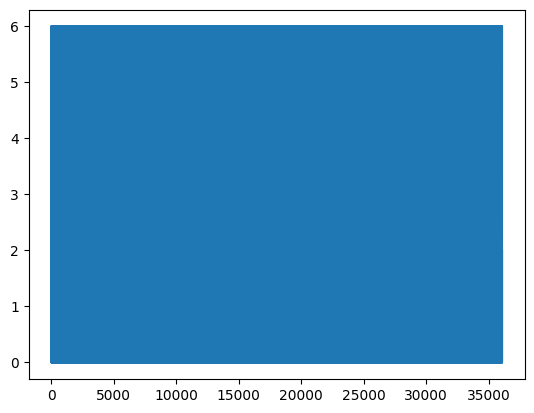

In [ ]:
plt.figure()
plt.plot(end_distances)
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


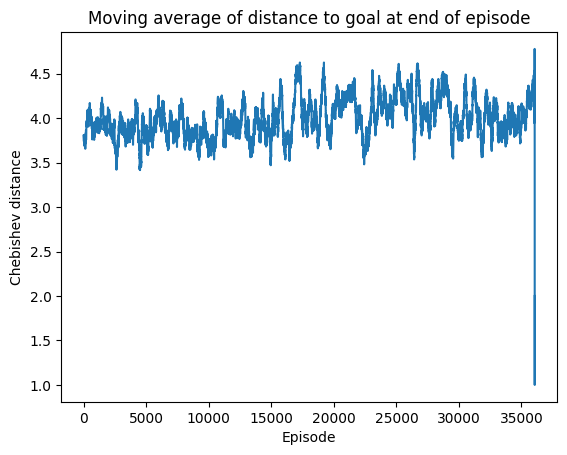

In [ ]:
ma_abs = list()
for i in range(62200):
    ma_abs.append(np.mean(np.array(end_distances[i:i+200])))
plt.figure()
plt.plot(ma_abs)
plt.title("Moving average of distance to goal at end of episode")
plt.xlabel("Episode")
plt.ylabel("Chebishev distance")
plt.show()

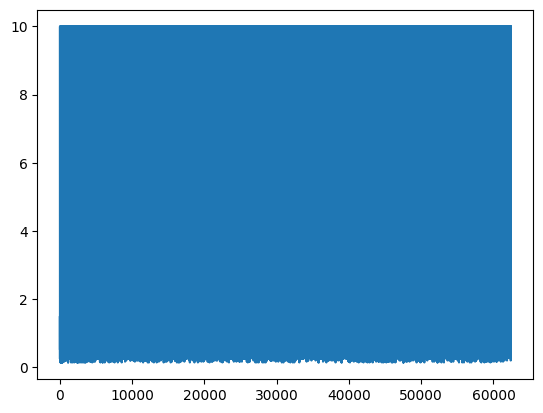

In [ ]:
plt.figure()
plt.plot(relative_distances)
plt.show()

In [ ]:
relative_new = ((np.array(end_distances) - np.array(start_distances)) / np.array(start_distances)) * 100

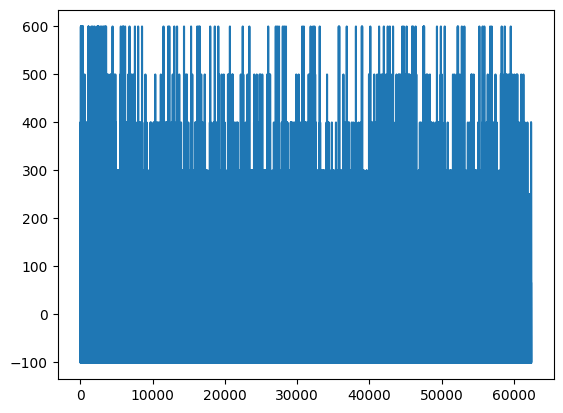

In [ ]:
plt.figure()
plt.plot(relative_new)
plt.show()

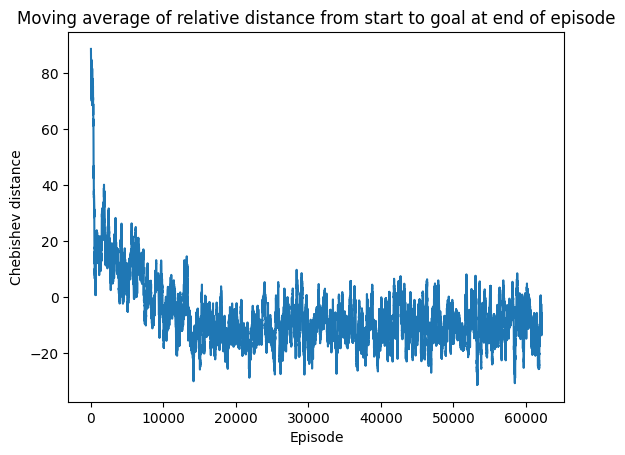

In [ ]:
ma_rel = list()
for i in range(62200):
    ma_rel.append(np.mean(np.array(relative_new[i:i+200])))
plt.figure()
plt.plot(ma_rel)
plt.title("Moving average of relative distance from start to goal at end of episode")
plt.xlabel("Episode")
plt.ylabel("Chebishev distance")
plt.show()

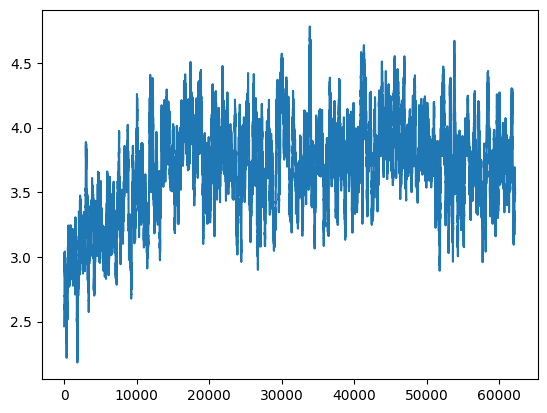

In [ ]:
ma_rel = list()
for i in range(62200):
    ma_rel.append(np.mean(np.array(relative_distances[i:i+200])))
plt.figure()
plt.plot(ma_rel)
plt.show()

In [ ]:
print(np.mean(episode_length[-240:]), all_loss[-1])
torch.save(env.policy_network.state_dict(), 'policy_network_architecture_hrtf_4.pth')


17.541666666666668 0.09110937267541885


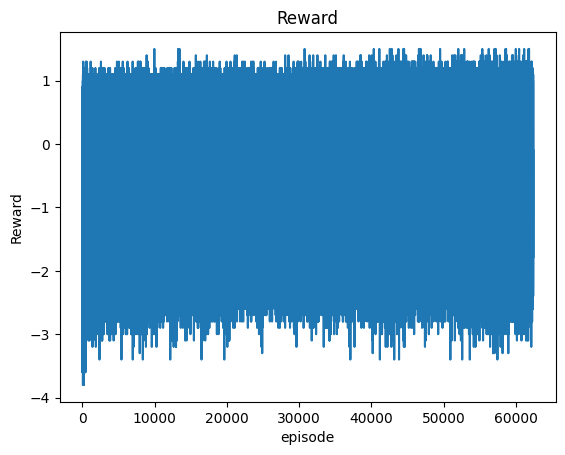

In [ ]:
plt.figure()
plt.plot(all_rewards)
plt.title("Reward")
plt.xlabel("episode")
plt.ylabel("Reward")
plt.show()

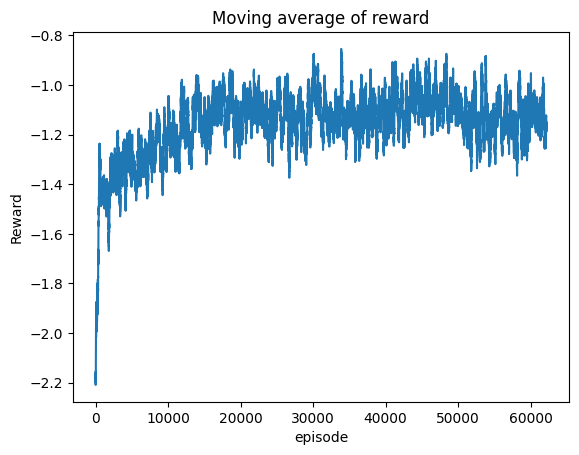

In [ ]:
ma_rew = list()
for i in range(62200):
    ma_rew.append(np.mean(np.array(all_rewards[i:i+200])))
plt.figure()
plt.plot(ma_rew)
plt.title("Moving average of reward")
plt.xlabel("episode")
plt.ylabel("Reward")
plt.show()

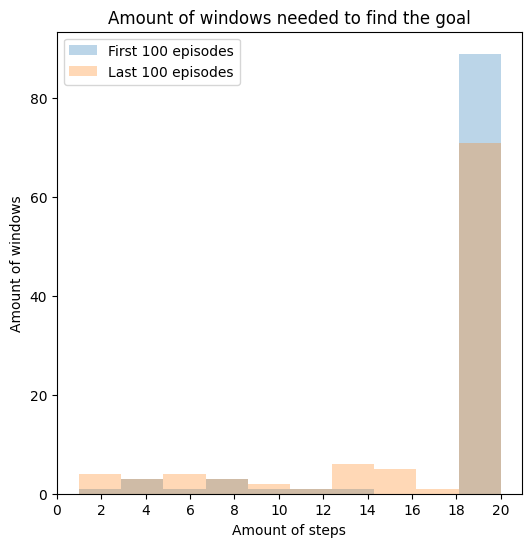

In [ ]:
# print(episode_length)
plt.figure(figsize=(6,6))
plt.hist(episode_length[:100], alpha=0.3, label='First 100 episodes')
plt.hist(episode_length[-100:], alpha=0.3, label='Last 100 episodes')
plt.title("Amount of windows needed to find the goal")
plt.xlabel("Amount of steps")
plt.ylabel("Amount of windows")
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.legend()
plt.show()

In [ ]:
# Print the model's state_dict
print("Model's state_dict:")
for param_tensor in env.policy_network.state_dict():
    print(param_tensor, "\t", env.policy_network.state_dict()[param_tensor].size())

# Access individual parameters
for param_tensor in env.policy_network.state_dict():
    print(param_tensor, "\t", env.policy_network.state_dict()[param_tensor])

In [ ]:
distances = list()

for ep in range(62400):
    distances.append(env.distance(env.get_initial_state(ep)[0].split("_")[16], env.get_initial_state(ep)[0].split("_")[18][:3], env.get_initial_state(ep)[0]))

In [ ]:
print(distances)

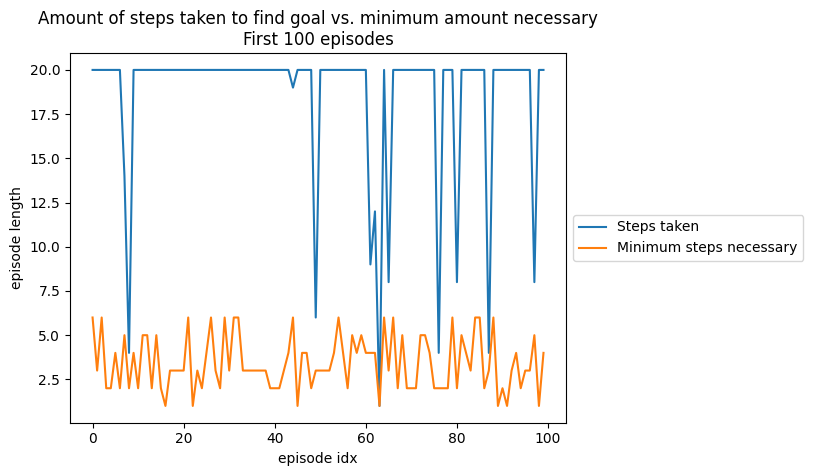

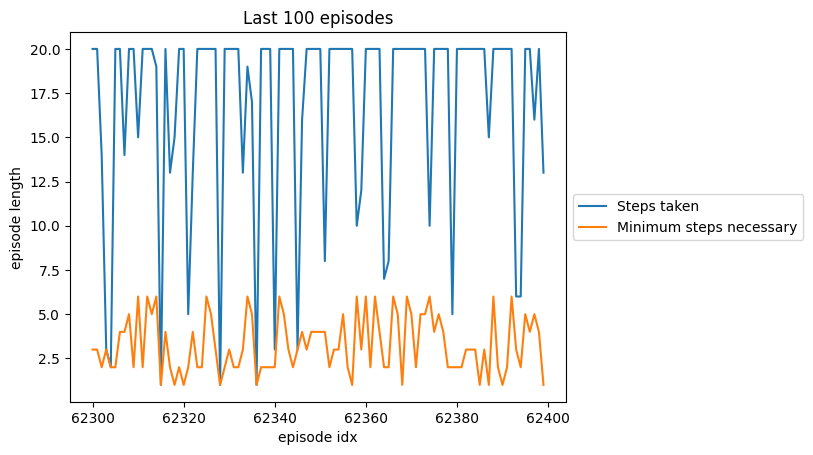

In [ ]:
plt.figure()
plt.plot(np.array(episode_length[:100]), label='Steps taken')
plt.plot(np.array(distances[:100]), label='Minimum steps necessary')
plt.title("Amount of steps taken to find goal vs. minimum amount necessary\nFirst 100 episodes")
plt.xlabel("episode idx")
plt.ylabel("episode length")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.plot(list(range(62300,62400)), list(np.array(episode_length[62300:62400])), label='Steps taken')
plt.plot(list(range(62300,62400)), np.array(distances[62300:62400]), label='Minimum steps necessary')
plt.xlabel("episode idx")
plt.ylabel("episode length")
plt.title("Last 100 episodes")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
ma = list()
for i in range(62200):
    ma.append(np.mean(np.array(episode_length[i:i+200])))

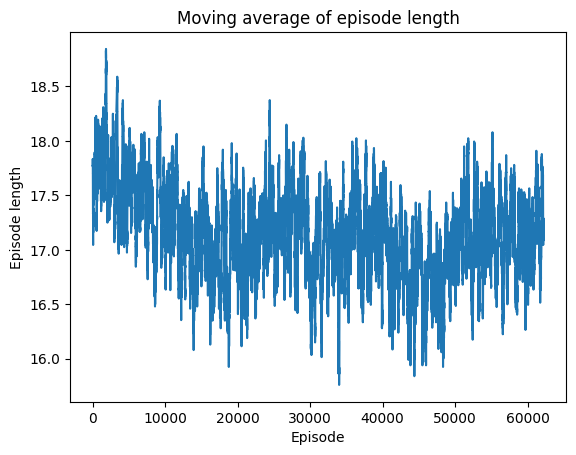

In [ ]:
plt.figure()
plt.plot(ma)
plt.title("Moving average of episode length")
plt.xlabel("Episode")
plt.ylabel("Episode length")
plt.show()

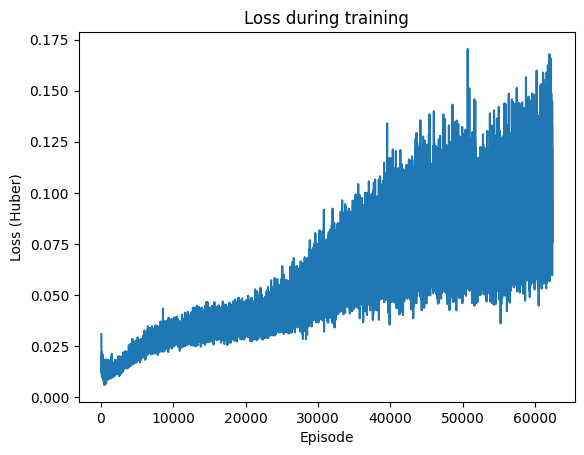

In [ ]:
plt.figure()
plt.plot(all_loss)
plt.xlabel("Episode")
plt.ylabel("Loss (Huber)")
plt.title("Loss during training")
plt.show()

In [ ]:
ma_loss = list()
for i in range(100,62200):
    ma_loss.append(np.mean(np.array(all_loss[i:i+200])))

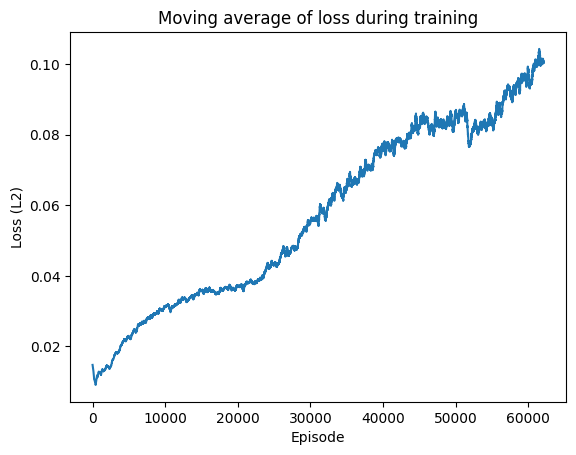

In [ ]:
plt.figure()
plt.plot(ma_loss)
plt.xlabel("Episode")
plt.ylabel("Loss (L2)")
plt.title("Moving average of loss during training")
plt.show()

In [ ]:
print(Q_vals)

tensor([[-1.2754, -1.2752, -1.2741, -1.4447, -1.3311, -1.5006, -1.5290, -1.5371]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
print(env.memory_buffer.class_idxs)

tensor([ 4786,  6840, 10534, 16245, 24296, 30908, 37333, 36276, 36284, 27484,
        19813, 13657, 13944,  4142,  5768,  8915, 14231, 20555, 37309, 34917,
        47750, 27073, 18501, 11698,  8520,  5654,  3676,  5309,  8301, 12316,
        20927, 28716, 34417, 32505, 21432, 12819,  8346,  5260,  3889,  3656,
         5695,  7754, 11985, 17182, 33759, 26077, 26189, 15206, 10084,  6401,
         4428,  3554,  4940,  5233,  7551, 10959, 15954, 16670, 17258, 14691,
        11619,  7893,  5538,  4000,  3735], device='cuda:0', dtype=torch.int32)


In [ ]:
episodes = 15600
epsilon = 0.0
# episode_length = list() #
# all_loss = list() #
# tau = 0.005
# start_distances = list() #
# end_distances = list() #
# absolute_distances = list() #
# relative_distances = list() #
# trajectories = list() #
# all_rewards = list()

for ep in tqdm(range(episodes)):
    trajectory = list()
    total_reward = 0

    # Initialise s1:
    brir_name, samp_name = env.get_initial_state(ep)
    az, el = env.get_azel_from_brir(brir_name)
    start_distances.append(env.distance(az, el, brir_name))
    trajectory.append([int(az) if int(az) <= 90 else -((-int(az))%360), int(el)])
    windows = env.open_sample_split(samp_name).to(device)
    brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
    observation = env.convolve_sound(windows[0:1], brir)[0:2].to(device)

    # Loop over all other windows:
    for window in range(1, env.n_windows):
        # Select action epsilon-greedily:
        Q_vals = env.get_Q_values_from_state(observation.unsqueeze(0))
        best_action = env.get_best_actions_from_Q_values(Q_vals)
        actions, action_idx = env.sample_action_epsilon_greedily(best_action, epsilon)

        # Execute action and observe reward:
        new_az, new_el = env.take_action(actions, az, el)
        trajectory.append([int(new_az) if int(new_az) <= 90 else -((-int(new_az))%360), int(new_el)])
        reward = env.get_reward(new_az, new_el, az, el, brir_name)
        total_reward += reward

        # Set new action:
        terminal = env.is_terminal(brir_name, new_az, new_el)
        if not terminal:
            brir_name = env.next_state(brir_name, new_az, new_el)
            # print(brir_name)
            brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
            new_observation = env.convolve_sound(windows[window:window+1], brir)[0:2].to(device)
        else:
            new_observation = torch.zeros(2, length_windows).to(device)


        # Store into buffer:
        env.append_buffer(observation, action_idx, new_observation, reward, terminal, new_az, new_el)

        # Go to next state:
        az, el = new_az, new_el
        observation = new_observation

        if terminal:
            episode_length.append(window)
            # DO STUFF FOR STATISTICS
            break
        if window == 19:
            episode_length.append(window+1)

    end_distances.append(env.distance(az, el, brir_name))
    all_rewards.append(total_reward)

    absolute_distances.append(start_distances[-1] - end_distances[-1])
    if end_distances[-1] != 0:
        relative_distances.append(start_distances[-1] / end_distances[-1])
    else:
        relative_distances.append(10)

    # Optimize model
    loss = env.train_model()
    all_loss.append(loss)

    trajectories.append(trajectory)

    if ep%240 == 0:
        # Update model (hard or soft?)
        # Hard update:
        # target_net = env.target_network.state_dict()
        # policy_net = env.policy_network.state_dict()
        # for key in policy_net:
        #     target_net[key] = policy_net[key]*tau + target_net[key] * (1-tau)
        # env.target_network.load_state_dict(target_net)
        env.target_network.load_state_dict(env.policy_network.state_dict())
        print(np.mean(episode_length[-240:]), all_loss[-1], np.mean(all_rewards[-240:]))
        torch.save(env.policy_network.state_dict(), 'policy_network_architecture_hrtf_4.pth')

    # if ep%2400 == 0:
    #     plt.figure()
    #     plt.plot(np.array(trajectory).T[0], np.array(trajectory).T[1])
    #     plt.xlim([-95,95])
    #     plt.ylim([-50,50])
    #     plt.show()


    epsilon -= (epsilon/episodes)

print(np.mean(episode_length[-240:]), all_loss[-1])
torch.save(env.policy_network.state_dict(), 'policy_network_architecture_hrtf_4.pth')


  0%|          | 0/15600 [00:00<?, ?it/s]<ipython-input-38-6161dca5db81>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
<ipython-input-38-6161dca5db81>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  brir = torch.tensor(env.open_brir(brir_name), dtype=torch.float, device=device)
  0%|          | 1/15600 [00:00<1:28:34,  2.94it/s]

17.179166666666667 0.13371291756629944 -1.15875


  2%|▏         | 242/15600 [00:38<38:03,  6.73it/s]

16.908333333333335 0.10582739114761353 -1.1041666666666665


  3%|▎         | 481/15600 [01:12<38:43,  6.51it/s]

17.154166666666665 0.09829477965831757 -1.1229166666666666


  5%|▍         | 721/15600 [01:48<1:09:03,  3.59it/s]

17.295833333333334 0.08339427411556244 -1.1879166666666665


  6%|▌         | 962/15600 [02:22<37:25,  6.52it/s]

16.679166666666667 0.11043733358383179 -0.9979166666666665


  8%|▊         | 1202/15600 [02:57<36:04,  6.65it/s]

17.008333333333333 0.12663081288337708 -1.0195833333333333


  9%|▉         | 1441/15600 [03:31<33:27,  7.05it/s]

17.054166666666667 0.14790880680084229 -1.0716666666666663


 11%|█         | 1682/15600 [04:05<34:31,  6.72it/s]

17.170833333333334 0.10141521692276001 -1.1012499999999998


 12%|█▏        | 1921/15600 [04:39<27:08,  8.40it/s]

16.7375 0.06878312677145004 -1.0583333333333333


 14%|█▍        | 2161/15600 [05:13<36:55,  6.06it/s]

16.6875 0.15688806772232056 -1.0279166666666664


 15%|█▌        | 2401/15600 [05:48<39:38,  5.55it/s]

17.420833333333334 0.11552050709724426 -1.1833333333333331


 17%|█▋        | 2642/15600 [06:22<30:42,  7.03it/s]

16.229166666666668 0.16986051201820374 -0.98625


 18%|█▊        | 2882/15600 [06:58<30:51,  6.87it/s]

17.6625 0.0862104594707489 -1.2854166666666667


 20%|██        | 3122/15600 [07:32<27:04,  7.68it/s]

16.666666666666668 0.09362246096134186 -1.0741666666666665


 22%|██▏       | 3362/15600 [08:06<29:00,  7.03it/s]

17.6625 0.1289367973804474 -1.2745833333333332


 23%|██▎       | 3602/15600 [08:40<28:55,  6.92it/s]

16.695833333333333 0.09284745901823044 -1.11625


 25%|██▍       | 3841/15600 [09:15<35:00,  5.60it/s]

16.954166666666666 0.1145264059305191 -1.1308333333333331


 26%|██▌       | 4082/15600 [09:49<32:01,  5.99it/s]

17.041666666666668 0.10409075766801834 -1.103333333333333


 28%|██▊       | 4322/15600 [10:24<28:16,  6.65it/s]

17.454166666666666 0.11697792261838913 -1.2695833333333333


 29%|██▉       | 4562/15600 [11:00<26:56,  6.83it/s]

16.7875 0.08954639732837677 -1.155


 31%|███       | 4802/15600 [11:35<25:34,  7.04it/s]

17.108333333333334 0.10528405010700226 -1.1304166666666664


 32%|███▏      | 5042/15600 [12:09<25:31,  6.89it/s]

16.891666666666666 0.1079922765493393 -1.1766666666666665


 34%|███▍      | 5282/15600 [12:44<24:37,  6.98it/s]

17.004166666666666 0.09463909268379211 -1.10625


 35%|███▌      | 5522/15600 [13:19<25:59,  6.46it/s]

17.141666666666666 0.12228897213935852 -1.1574999999999998


 37%|███▋      | 5761/15600 [13:54<30:39,  5.35it/s]

16.8875 0.10565067082643509 -1.1641666666666666


 38%|███▊      | 6002/15600 [14:30<21:27,  7.45it/s]

16.970833333333335 0.09926286339759827 -1.1849999999999998


 40%|████      | 6242/15600 [15:03<21:43,  7.18it/s]

15.829166666666667 0.14397507905960083 -1.01875


 42%|████▏     | 6482/15600 [15:42<22:31,  6.75it/s]

16.8875 0.08786539733409882 -1.1583333333333334


 43%|████▎     | 6721/15600 [16:16<25:37,  5.77it/s]

16.741666666666667 0.11137937009334564 -1.1187499999999997


 45%|████▍     | 6962/15600 [16:50<23:37,  6.09it/s]

16.504166666666666 0.10288981348276138 -1.0883333333333332


 46%|████▌     | 7201/15600 [17:25<21:49,  6.41it/s]

16.925 0.12842059135437012 -1.0516666666666665


 48%|████▊     | 7442/15600 [17:59<19:27,  6.99it/s]

16.625 0.12892192602157593 -1.0845833333333332


 49%|████▉     | 7682/15600 [18:34<19:33,  6.75it/s]

17.2125 0.09911447763442993 -1.1908333333333332


 51%|█████     | 7922/15600 [19:08<16:49,  7.61it/s]

16.541666666666668 0.12024683505296707 -1.0258333333333334


 52%|█████▏    | 8162/15600 [19:42<19:01,  6.52it/s]

17.108333333333334 0.13251100480556488 -1.1566666666666667


 54%|█████▍    | 8402/15600 [20:17<16:18,  7.36it/s]

17.241666666666667 0.08952578157186508 -1.165833333333333


 55%|█████▌    | 8641/15600 [20:51<21:03,  5.51it/s]

17.1375 0.08806195855140686 -1.1504166666666664


 57%|█████▋    | 8882/15600 [21:26<17:32,  6.38it/s]

16.629166666666666 0.12323065847158432 -1.1191666666666662


 58%|█████▊    | 9122/15600 [22:01<16:22,  6.60it/s]

17.166666666666668 0.11752902716398239 -1.1495833333333332


 60%|██████    | 9362/15600 [22:36<16:00,  6.50it/s]

17.004166666666666 0.07841053605079651 -1.1316666666666666


 62%|██████▏   | 9602/15600 [23:10<15:05,  6.62it/s]

17.366666666666667 0.11235592514276505 -1.2408333333333332


 63%|██████▎   | 9842/15600 [23:44<12:45,  7.52it/s]

16.470833333333335 0.14693763852119446 -1.0437499999999997


 65%|██████▍   | 10081/15600 [24:19<16:48,  5.47it/s]

17.508333333333333 0.14748775959014893 -1.2937499999999997


 66%|██████▌   | 10321/15600 [24:53<14:42,  5.98it/s]

16.608333333333334 0.11961670219898224 -1.0766666666666667


 68%|██████▊   | 10562/15600 [25:28<12:20,  6.80it/s]

17.3875 0.1217486709356308 -1.2004166666666667


 69%|██████▉   | 10801/15600 [26:03<10:40,  7.49it/s]

16.808333333333334 0.14612369239330292 -1.132083333333333


 71%|███████   | 11042/15600 [26:37<10:35,  7.17it/s]

17.170833333333334 0.10245922207832336 -1.1358333333333335


 72%|███████▏  | 11282/15600 [27:12<10:15,  7.02it/s]

17.245833333333334 0.0729367733001709 -1.3308333333333333


 74%|███████▍  | 11522/15600 [27:46<10:14,  6.64it/s]

17.258333333333333 0.10630445182323456 -1.2054166666666666


 75%|███████▌  | 11761/15600 [28:20<10:32,  6.07it/s]

17.1125 0.11516806483268738 -1.2320833333333332


 77%|███████▋  | 12002/15600 [28:54<09:29,  6.32it/s]

16.2875 0.08342266082763672 -1.0474999999999999


 78%|███████▊  | 12242/15600 [29:30<07:18,  7.66it/s]

17.429166666666667 0.08829246461391449 -1.2379166666666666


 80%|████████  | 12482/15600 [30:05<07:19,  7.09it/s]

17.025 0.11131055653095245 -1.2424999999999997


 82%|████████▏ | 12722/15600 [30:39<06:51,  7.00it/s]

16.6 0.09549465775489807 -1.0291666666666666


 83%|████████▎ | 12962/15600 [31:13<06:33,  6.70it/s]

16.091666666666665 0.08714436739683151 -1.0370833333333331


 85%|████████▍ | 13201/15600 [31:47<06:24,  6.24it/s]

17.229166666666668 0.11226576566696167 -1.1275


 86%|████████▌ | 13441/15600 [32:22<06:37,  5.43it/s]

16.625 0.10464079678058624 -1.1083333333333334


 88%|████████▊ | 13682/15600 [32:57<05:18,  6.03it/s]

17.308333333333334 0.14464375376701355 -1.1099999999999999


 89%|████████▉ | 13922/15600 [33:32<04:03,  6.89it/s]

16.529166666666665 0.11713708937168121 -1.05375


 91%|█████████ | 14162/15600 [34:07<03:30,  6.82it/s]

17.3625 0.11036980152130127 -1.2499999999999998


 92%|█████████▏| 14402/15600 [34:41<02:44,  7.30it/s]

16.870833333333334 0.09687504172325134 -1.1199999999999999


 94%|█████████▍| 14642/15600 [35:15<02:21,  6.79it/s]

16.783333333333335 0.11508055031299591 -1.2204166666666665


 95%|█████████▌| 14882/15600 [35:49<01:38,  7.29it/s]

16.195833333333333 0.12926605343818665 -0.9920833333333332


 97%|█████████▋| 15121/15600 [36:24<01:36,  4.96it/s]

16.991666666666667 0.10281043499708176 -1.1275000000000002


 98%|█████████▊| 15361/15600 [36:59<00:37,  6.41it/s]

16.445833333333333 0.10694701969623566 -0.9958333333333331


100%|██████████| 15600/15600 [37:34<00:00,  6.92it/s]


16.708333333333332 0.1006041094660759
